####  7Twelve Portfolio
* This notebook reproduces the charts in the blog article: [Retirement Portfolio-7Twelve](http://appliedvalueinvestor.com/2017/09/10/retirement-portfolio-7twelve/)

In [1]:
### Setup the environment
import os,sys
import pandas as pd
import pandas_datareader as web
import numpy as np
from datetime import datetime as dt
import matplotlib
import seaborn as sns
#%matplotlib inline
import pylab as py
py.ion()

import scipy as sp
import scipy.optimize as scopt
import scipy.stats as spstats
import warnings
warnings.filterwarnings('ignore')

HOME=os.environ['HOME']
file_path = os.path.dirname(os.path.realpath('__file__'))
sys_path='%s/..'%file_path
sys.path.append(sys_path)
from investmenttools import PortfolioBuilder as PB
reload(PB)

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 78)
pd.set_option('precision', 3)

In [2]:
## Portfolio ticker
nme=['BIV','DBC','PCY','SHYG','TIP','VAW','VB','VNQ','VEU','VO','VTV','VWO']
nfe=['SHY','AGG','SCHP','EMB','FREL','IJH','IVV','IEFA','VBR','FMAT','IEMG']
nTD=['AGG','DBC','IJH','IVV','PCY','TIP','VAW','VBR','VEA','VGSH','VNQ','VWO']
n712=['ITOT', 'SCHM', 'VBR', 'VEU', 'SCHE', 'VNQ', 'VAW', 'AGG', 'SCHP', 'IGOV', 'SHV','DBC']

nVa=['VSS', 'VOO', 'VGPMX', 'VO', 'VDC', 'VNQ', 'VWEHX', 'VCSH','VIPSX']

cc=list(set.union(set(nme),set(nfe),set(nTD),set(nVa)))
print cc
wVa=[.09,0.3,0.05,.03,.16,.07,.07,.18,.05]
## Portfolio Weight
w712=12*[0.08333]
wme=w712
wTD=w712
wfe=11*[0.0909]

wcc=32*[0.03125]

['VB', 'PCY', 'FMAT', 'IEMG', 'FREL', 'AGG', 'SHY', 'VEA', 'TIP', 'VO', 'VBR', 'VDC', 'VEU', 'IJH', 'VTV', 'VGSH', 'VWEHX', 'SHYG', 'VOO', 'VSS', 'SCHP', 'IEFA', 'DBC', 'EMB', 'VGPMX', 'VAW', 'IVV', 'VWO', 'VIPSX', 'VNQ', 'BIV', 'VCSH']


In [3]:
## Define python module to download ticker data
from selenium import webdriver
from time import mktime
from xvfbwrapper import Xvfb

def WaitForDownload(datafile):
    bul=0
    while not bul:
        if os.path.isfile(datafile):
            bul=1
        else:
            bul=0

def download_ticker(ticker,sd,ed):
    vdisplay=Xvfb()
    sd_unix=mktime(sd.timetuple())
    ed_unix=mktime(ed.timetuple())
    URL='https://finance.yahoo.com/quote/%s/history?period1=%d&period2=%d&interval=1d&filter=history&frequency=1d'%(ticker.upper(),sd_unix,ed_unix)
    print URL
    #vdisplay.start() ## uncomment to prevent browser window from opening 
    driver=webdriver.Chrome()
    driver.get(URL)
    driver.implicitly_wait(100)
    elem=driver.find_element_by_link_text('Download Data')
    elem.click()
    datafile='%s/Downloads/%s.csv'%(HOME,ticker.upper())
    WaitForDownload(datafile)
    #assert os.path.isfile(datafile)
    mv_cmd='mv %s/Downloads/%s.csv %s/../Data'%(HOME,ticker.upper(),file_path)
    
    os.system(mv_cmd)
    #vdisplay.stop() ## uncomment to prevent browser window from opening 
    driver.close()    
    
## Define python module to read ticker data from csv file downloaed from Yahoo-finance
def get_data_from_csv(filename,ticker):
	data=pd.read_csv(filename)
	data.set_index('Date',inplace=True)
	data.rename(columns={'Close':ticker},inplace=True)
	data=data[ticker]
	return data.astype('float32')

In [4]:
# Download data
## Not running this again, as I already downloaded the data
for s in nTD:
    print s
    download_ticker(s.upper(),dt(2012,1,1),dt(2017,8,31))



AGG
https://finance.yahoo.com/quote/AGG/history?period1=1325404800&period2=1504162800&interval=1d&filter=history&frequency=1d
DBC
https://finance.yahoo.com/quote/DBC/history?period1=1325404800&period2=1504162800&interval=1d&filter=history&frequency=1d
IJH
https://finance.yahoo.com/quote/IJH/history?period1=1325404800&period2=1504162800&interval=1d&filter=history&frequency=1d
IVV
https://finance.yahoo.com/quote/IVV/history?period1=1325404800&period2=1504162800&interval=1d&filter=history&frequency=1d
PCY
https://finance.yahoo.com/quote/PCY/history?period1=1325404800&period2=1504162800&interval=1d&filter=history&frequency=1d
TIP
https://finance.yahoo.com/quote/TIP/history?period1=1325404800&period2=1504162800&interval=1d&filter=history&frequency=1d
VAW
https://finance.yahoo.com/quote/VAW/history?period1=1325404800&period2=1504162800&interval=1d&filter=history&frequency=1d
VBR
https://finance.yahoo.com/quote/VBR/history?period1=1325404800&period2=1504162800&interval=1d&filter=history&frequ

In [5]:
#Collate portfolio data

data_712={};data_me={};data_fe={};data_Va={};data_TD={};data_cc={}

for s in n712:
    data_712[s]=get_data_from_csv('%s/../Data/%s.csv'%(file_path,s.upper()),s)
portfolio_712=pd.DataFrame(data_712.values()).T 
portfolio_712.dropna(inplace=True)
portfolio_712.index=pd.to_datetime(portfolio_712.index)

for s in nme:
    data_me[s]=get_data_from_csv('%s/../Data/%s.csv'%(file_path,s.upper()),s)
portfolio_me=pd.DataFrame(data_me.values()).T  
portfolio_me.dropna(inplace=True)
portfolio_me.index=pd.to_datetime(portfolio_me.index)

for s in nfe:
    data_fe[s]=get_data_from_csv('%s/../Data/%s.csv'%(file_path,s.upper()),s)
portfolio_fe=pd.DataFrame(data_fe.values()).T  
portfolio_fe.dropna(inplace=True)
portfolio_fe.index=pd.to_datetime(portfolio_fe.index)

for s in nVa:
    data_Va[s]=get_data_from_csv('%s/../Data/%s.csv'%(file_path,s.upper()),s)
portfolio_Va=pd.DataFrame(data_Va.values()).T  
portfolio_Va.dropna(inplace=True)
portfolio_Va.index=pd.to_datetime(portfolio_Va.index)

for s in nTD:
    data_TD[s]=get_data_from_csv('%s/../Data/%s.csv'%(file_path,s.upper()),s)
portfolio_TD=pd.DataFrame(data_TD.values()).T  
portfolio_TD.dropna(inplace=True)
portfolio_TD.index=pd.to_datetime(portfolio_TD.index)

for s in cc:
    data_cc[s]=get_data_from_csv('%s/../Data/%s.csv'%(file_path,s.upper()),s)
portfolio_cc=pd.DataFrame(data_cc.values()).T  
portfolio_cc.dropna(inplace=True)
portfolio_cc.index=pd.to_datetime(portfolio_cc.index)

print portfolio_TD.head(5)
print wVa

              PCY   VGSH     AGG  ...      VEA    IJH    VAW
Date                              ...                       
2012-01-03  27.11  60.89  110.03  ...    31.45  88.55  75.16
2012-01-04  27.27  60.95  109.88  ...    31.27  88.30  75.72
2012-01-05  27.13  60.92  110.03  ...    30.82  88.98  75.86
2012-01-06  27.12  60.91  110.12  ...    30.46  88.91  75.80
2012-01-09  27.07  60.92  110.03  ...    30.53  89.40  75.99

[5 rows x 12 columns]
[0.09, 0.3, 0.05, 0.03, 0.16, 0.07, 0.07, 0.18, 0.05]


In [6]:
## Compute Portfolio Variance
s712=PB.calc_portfolio_var(portfolio_712,w712)
sme=PB.calc_portfolio_var(portfolio_me,wme)
sfe=PB.calc_portfolio_var(portfolio_fe,wfe)
sVa=PB.calc_portfolio_var(portfolio_Va,wVa)
sTD=PB.calc_portfolio_var(portfolio_TD,wTD)
scc=PB.calc_portfolio_var(portfolio_cc,wcc)
All_Var=[s712,sme,sfe]
print 'Var fo 712:',s712
print 'Var fo me:',sme
print 'Var fo fe:',sfe
print 'Var fo Va:',sVa
print 'Var fo TD:',sTD
print 'Var fo cc:',scc
portfolio_Va.cov().dot(wVa).dot(wVa)

Var fo 712: 15.25723166658586
Var fo me: 11.408003130864842
Var fo fe: 20.244558709475072
Var fo Va: 176.5375086125268
Var fo TD: 53.01531729873875
Var fo cc: 14.449436154449817


176.5375086125268

In [12]:
## Compute Portfolio returns with annual rebalancing
r712=[];rme=[];rfe=[];rVa=[];rTD=[];rcc=[]
r712=PB.Backtest_Annual_Rebalance(n712,w712,dt(2015,2,5),dt(2018,1,30),initial=10000,stk_data=portfolio_712)
rme=PB.Backtest_Annual_Rebalance(nme,wme,dt(2015,2,5),dt(2018,1,30),initial=10000,stk_data=portfolio_me)
rfe=PB.Backtest_Annual_Rebalance(nfe,wfe,dt(2015,2,5),dt(2018,1,30),initial=10000,stk_data=portfolio_fe)
rVa=PB.Backtest_Annual_Rebalance(nVa,wVa,dt(2015,2,5),dt(2018,1,30),initial=10000,stk_data=portfolio_Va)
rTD=PB.Backtest_Annual_Rebalance(nTD,wTD,dt(2015,2,5),dt(2018,1,30),initial=10000,stk_data=portfolio_TD)
rcc=PB.Backtest_Annual_Rebalance(cc,wcc,dt(2015,2,5),dt(2018,1,30),initial=10000,stk_data=portfolio_cc)

IndexError: single positional indexer is out-of-bounds

In [9]:
## Compute Annual Returns
P712_dp=PB.calc_daily_returns(r712[['Total','Cash']].sum(axis=1))
P712_ap=100*PB.calc_annual_returns(P712_dp)
P712_ap.name='712'

Pme_dp=PB.calc_daily_returns(rme[['Total','Cash']].sum(axis=1))
Pme_ap=100*PB.calc_annual_returns(Pme_dp)
Pme_ap.name='me'

Pfe_dp=PB.calc_daily_returns(rfe[['Total','Cash']].sum(axis=1))
Pfe_ap=100*PB.calc_annual_returns(Pfe_dp)
Pfe_ap.name='fe'

PVa_dp=PB.calc_daily_returns(rVa[['Total','Cash']].sum(axis=1))
PVa_ap=100*PB.calc_annual_returns(PVa_dp)
PVa_ap.name='Va'

PTD_dp=PB.calc_daily_returns(rTD[['Total','Cash']].sum(axis=1))
PTD_ap=100*PB.calc_annual_returns(PTD_dp)
PTD_ap.name='TD'

Pcc_dp=PB.calc_daily_returns(rcc[['Total','Cash']].sum(axis=1))
Pcc_ap=100*PB.calc_annual_returns(Pcc_dp)
Pcc_ap.name='CC'

Annual_Returns=pd.concat([P712_ap,Pme_ap,Pfe_ap,PVa_ap,PTD_ap,Pcc_ap],axis=1)
print Annual_Returns

print '\n Average Annual Returns:'
avg_annual_returns=Annual_Returns.mean(axis=0)
print avg_annual_returns

        712     me     fe     Va     TD     CC
2015 -8.499 -9.399 -6.516 -3.982 -8.352 -7.084
2016  9.394  9.530  8.675  7.411  9.492  8.351
2017  5.325  4.798  6.231  6.132  4.136  5.401

 Average Annual Returns:
712    2.073
me     1.643
fe     2.797
Va     3.187
TD     1.759
CC     2.223
dtype: float64


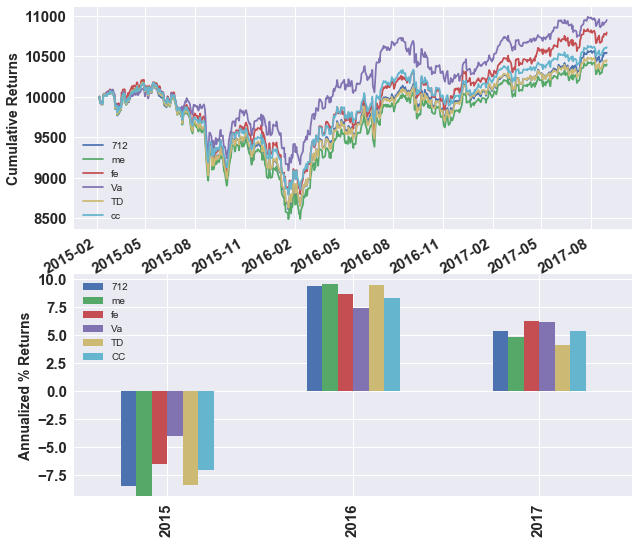

In [10]:
## Plot Cumulative And Annual Returns

py.figure(figsize=(10,10))
ax1=py.subplot(211)
py.hold('on')
r712[['Total','Cash']].sum(axis=1).plot(ax=ax1)
rme[['Total','Cash']].sum(axis=1).plot(ax=ax1)
rfe[['Total','Cash']].sum(axis=1).plot(ax=ax1)
rVa[['Total','Cash']].sum(axis=1).plot(ax=ax1)
rTD[['Total','Cash']].sum(axis=1).plot(ax=ax1)
rcc[['Total','Cash']].sum(axis=1).plot(ax=ax1)

py.xticks(fontsize=15,fontweight='bold')
py.yticks(fontsize=15,fontweight='bold')
py.ylabel('Cumulative Returns',fontweight='bold',fontsize=14)
py.xlabel('')
py.legend(['712','me','fe','Va','TD','cc'],loc='best')

ax2=py.subplot(212)
Annual_Returns.plot(kind='bar',ax=ax2)
py.xticks(fontsize=15,fontweight='bold');
py.yticks(fontsize=15,fontweight='bold');
py.ylabel('Annualized % Returns',fontweight='bold',fontsize=14)


In [ ]:
## Print Risk Return Profile

py.figure(figsize=(10,5));
py.plot(All_Var,avg_annual_returns.values,'.',markersize=15)
py.xticks(fontweight='bold',fontsize=15)
py.yticks(fontweight='bold',fontsize=15)
py.xlabel('Portfolio-Variance',fontweight='bold',fontsize=15)
py.ylabel('Average Annual Returns',fontweight='bold',fontsize=15)

## Perfect straiht line!!!!! quite unusall 